### Imports

In [1]:
import numpy as np


import pandas as pd
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm


### Data Extraction

In [2]:
# Set Data Extraction parameters
start_date = "2017-01-01"
end_date = "2023-01-01"
file_name = "data/data_etf.csv"
file_name_coint = "data/data_pairs.csv"
load_existing = True
load_coint_pairs = True

In [3]:
if not load_existing:
    symbols = get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
    symbols = list(symbols.index.values)
    data = DataReader(name=symbols, data_source='yahoo', start=start_date, end=end_date)["Adj Close"]
    data.to_csv(file_name)

In [4]:
data = pd.read_csv(file_name)
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")

In [5]:
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)

In [6]:
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,0.014753,0.311722
AAXJ,-0.038123,0.090672
ACWI,0.332246,-0.187269
ACWX,-0.143712,-0.198211
ADRE,-0.003167,0.417291


In [7]:
# We use the elbow method to find the optimal clusters
X = df_scaled.copy()
K = range(2, 15)
distortions = []
for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("optimal k:", c)

optimal k: 6


In [8]:
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

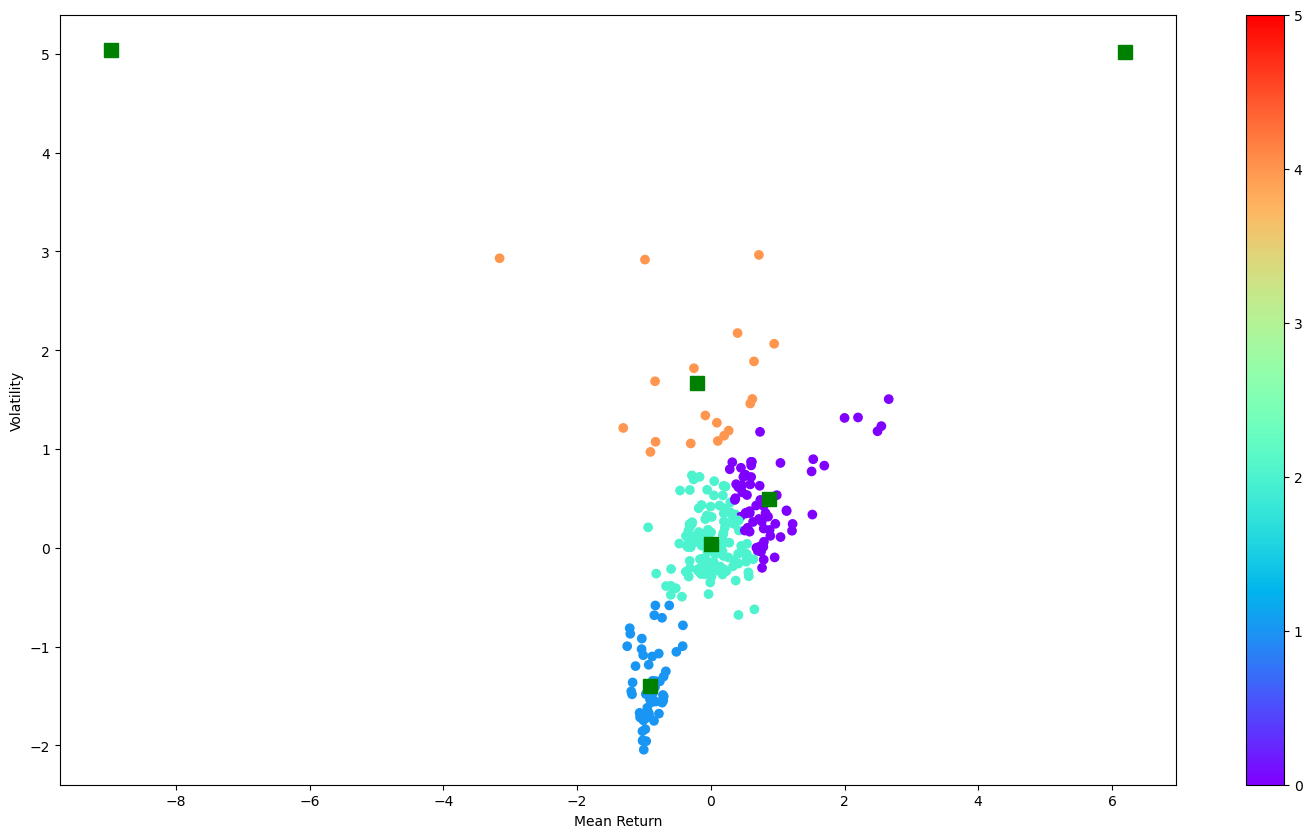

In [9]:
cent = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(cent[:,0], cent[:,1], "sg", markersize=10)
plt.show()

In [10]:
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio

In [11]:
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in clusters_clean.index:
        base_label = clusters_clean[base_asset]
        
        for compare_asset in clusters_clean.index:
            compare_label = clusters_clean[compare_asset]
            
            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)
            
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset": base_asset, 
                                               "compare_asset": compare_asset, 
                                               "label": base_label})
                    
    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    df_coint.to_csv(file_name_coint)

In [12]:
df_coint = pd.read_csv(file_name_coint).iloc[:, 1:]
df_coint.head()

,base_asset,compare_asset,label
0,AADR,DAX,0
1,FPXI,IBB,0
2,FNX,PSCC,0
3,FNX,INDY,0
4,FNK,VYMI,0


In [13]:
#unique list of pairs
coint_assets = [df_coint["base_asset"].values]
coint_assets.append(df_coint["compare_asset"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AADR', 'AAXJ', 'ACWI', 'ACWX', 'ADRE'], dtype=object)

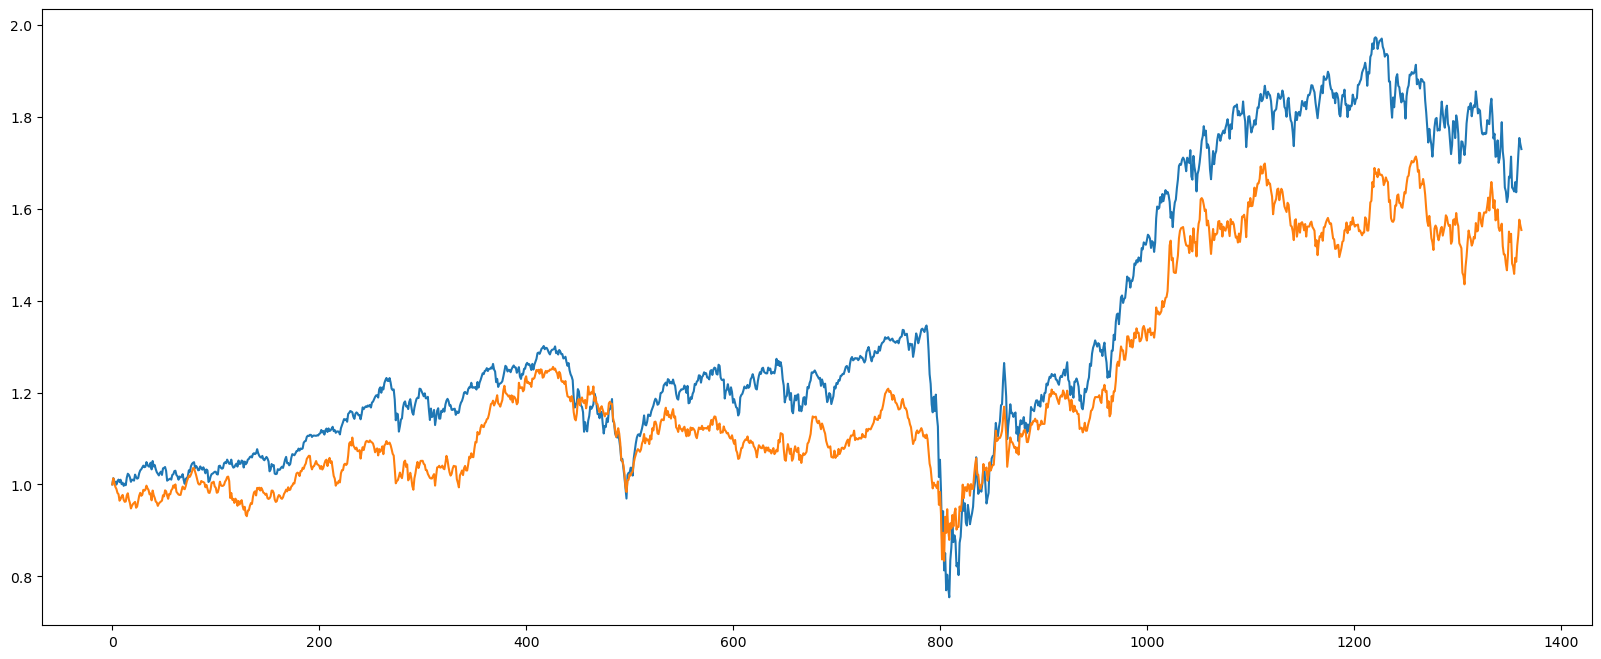

In [14]:
#review of a random pair
asset_1 = "FNX"
asset_2 = "PSCC"
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()
plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()

In [15]:
#calculate spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)

In [16]:
#calculate z_score
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std

### Save Data

In [18]:
# Save Data
capped = []
for z in z_score:
    z = 6 if z > 6 else z
    z = -6 if z <-6 else z
    capped.append(z)
df_save = data[[asset_1, asset_2]].copy()
df_save["Spread"] = spread
df_save["ZScore"] = capped
df_save.dropna(inplace=True)
df_save.columns = ["Asset1", "Asset2", "Spread", "ZScore"]
df_save.to_csv("data/k_mean_pairs.csv")
df_save.head()

,Asset1,Asset2,Spread,ZScore
Date,,,,
2017-05-25,55.777828,64.719444,-3.802045,-0.318249
2017-05-26,55.777828,64.560036,-3.655295,-0.205679
2017-05-30,55.500473,63.837887,-3.267849,0.135852
2017-05-31,55.452652,63.903545,-3.376115,0.013782
2017-06-01,56.447315,64.494370,-2.925357,0.435727
